In [66]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 14:13:15 2023

@author: souchaud
"""
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import sys
import shutil

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

Device for torch operations: cpu


In [68]:
def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a = None, coeff_rep = None):
    """
    Calculate the force field within the focal box.

    Parameters
    ----------
    - coordinates_diff: Tensor representing the positions of particles in the focal box.

    Returns
    -------
    - force_field: Tensor representing the force field within the focal box.

    """  
    Rlim = 0.000001
    R = torch.norm(coordinates_diff, dim=2)
    # prevents the repulsion force from exploding when approaching its maximum value
    R = torch.where(R > Rlim*torch.ones(1, device=device),
                  R, Rlim*torch.ones(1, device=device)).to(device)
    
    ###########  R**2 adhesion force ###########
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(a*R**2+b*R+c), torch.zeros_like(R)).to(device)
    
    ########### a*R**alpha + b ############
    alpha = coeff_a
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(Fadh/((R0**alpha)-(Req**alpha)))*((R**alpha)-(Req**alpha)), torch.zeros_like(R)).to(device)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        function_adh(R, Req, R0, Fadh, alpha, coeff_a=coeff_a), torch.zeros_like(R)).to(device)

    # The repulsion force is calculated wherever R<Req
    ########### Linear adhesion force ########### 
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req)), torch.zeros_like(R)).to(device)

    ###########  Repulsion force linear ########## 
    # force = torch.where(R < Req,
    #                     - Frep*R*(1/Req-1/R), force).to(device)
    ########### Repulsion forces in 1/R ########### 
    force = torch.where(R <= Req,
                        - Frep*coeff_rep*(1/Req-1/R), force).to(device)

    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim = 2), axis=1)

    return force_field


def function_adh(R, Req, R0, Fadh, alpha, coeff_a):
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # return -(a*R**2+b*R+c)
    return -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req))

# def function_adh(R, Req, R0, Fadh, alpha,):
#     return -(Fadh/((R0-Req)**alpha))*((R-Req)**alpha)

def autovel(dX, n, tau, noise, dt):
    """
    Compute the new cells direction.

    Parameters
    ----------
    dX : déplacement
        DESCRIPTION.
    n : direction
        DESCRIPTION.

    Returns
    -------
    n : TYPE
        DESCRIPTION.

    """
    # Compute the angle between the input vector and the x-axis
    theta = torch.atan2(dX[:, 1], dX[:, 0]).to(device)
    # Compute the absolute value of the input vector
    # dXabs = torch.norm(dX, p=2, dim=1).to(device)
    # Normalize the input vector and slightly reduce its magnitude
    dX_norm = torch.nn.functional.normalize(dX, dim = 1)*0.9999999
    # Compute the change in angle based on the orientation vector (n)
    dtheta = torch.arcsin(
        (n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau
    # Generate random noise for angle perturbation
    rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1,
                    device=device) - 0.5)) * np.sqrt(dt)
    # Update the angle by adding the change in angle, random noise, and the previous angle
    theta += dtheta + rnd[:, 0]
    # Update the orientation vector (n) based on the updated angle
    # n[:, 0] = torch.cos(theta)
    # n[:, 1] = torch.sin(theta)
    n[:, 0].copy_(torch.cos(theta))
    n[:, 1].copy_(torch.sin(theta))
    return n


def plot_environment(cells, space_size,req, path_saving=None, iteration=None):
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    # Combine cells from both populations
    all_cells = population1.cells + population2.cells

    # Extract x and y coordinates
    x = [cell.position[0].item() for cell in all_cells]
    y = [cell.position[1].item() for cell in all_cells]

    # Create a list of colors corresponding to each cell
    colors = ['blue'] * len(population1.cells) + \
        ['red'] * len(population2.cells)

    # Plot all cells at once with the specified colors
    axis.scatter(x, y, s=3, color=colors,alpha=0.5, rasterized=True)

    # plt.title('Cell Movement')
    plt.xlabel('X position (micrometers)')
    plt.ylabel('Y position (micrometers)')
    # plt.axis('off')
    plt.axis('off')
    plt.savefig(f'{path_saving}image_{iteration}.png',
                bbox_inches='tight', dpi=400, pad_inches = 0)

    plt.show()
    plt.close()
    print(iteration)


def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):

    b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    c = -Req*(a*Req + (Fadh-a*(R0**2-Req**2))/(R0-Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    print("Req = ", Req)
    print("R0 = ", R0)
    print("Fadh = ", Fadh)
    print("Frep = ", Frep)

    axis.plot(np.arange(pas, Req, pas), [
              R*Frep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Mathieu')
    axis.plot(np.arange(pas, Req, pas), [
              Frep*coeff_rep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Alex')

    axis.plot(np.arange(Req, R0, pas), [
              (Fadh/(R0-Req))*(R-Req) for R in np.arange(Req, R0, pas)], label='adhline')
    axis.plot(np.arange(Req, R0, pas), [-function_adh(R, Req, R0, Fadh, alpha=0.5, coeff_a=30)
                                        for R in np.arange(Req, R0, pas)], alpha=0.5, label='adh_Alex')
    axis.plot(np.arange(Req, R0, pas), [(a*R**2+b*R+c)
              for R in np.arange(Req, R0, pas)], label="square")

    # (Fadh/(R0-Req))*R+Fadh*Req/(R0-Req)

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

In [69]:
class CellAgent:
    def __init__(self, position, velocity, velocity_magnitude, persistence, space_size):
        # We add the inital position to make some calc later.
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)


In [70]:
class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        velocities = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1) * self.velocity_magnitude

        if self.min_distance != 0:
          # Create a grid with cell size equal to the minimum distance
          grid_size = int(np.ceil(self.space_size / self.min_distance))
          grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]

          valid_positions = []
          for i in range(self.num_cells):
              valid = True

              # Compute the cell's grid indices
              grid_x = int(positions[i, 0] / self.min_distance)
              grid_y = int(positions[i, 1] / self.min_distance)

              # Check neighboring cells in the grid
              for dx in [-1, 0, 1]:
                  for dy in [-1, 0, 1]:
                      nx = grid_x + dx
                      ny = grid_y + dy

                      # Check if the neighboring grid cell is valid
                      if 0 <= nx < grid_size and 0 <= ny < grid_size:
                          for cell_pos in grid[nx][ny]:
                              # Check the distance between the current cell and the neighboring cells
                              if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                  valid = False
                                  break
                      if not valid:
                          break
                  if not valid:
                      break
              if valid:
                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
              else:
                  # Generate a new random position until a valid one is found
                  while not valid:
                      positions[i] = torch.rand((1, 2), device=device) * self.space_size

                      # Compute the updated cell's grid indices
                      grid_x = int(positions[i, 0] / self.min_distance)
                      grid_y = int(positions[i, 1] / self.min_distance)

                      # Check neighboring cells in the grid
                      valid = True
                      for dx in [-1, 0, 1]:
                          for dy in [-1, 0, 1]:
                              nx = grid_x + dx
                              ny = grid_y + dy

                              # Check if the neighboring grid cell is valid
                              if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                  for cell_pos in grid[nx][ny]:
                                      # Check the distance between the current cell and the neighboring cells
                                      if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                          valid = False
                                          break
                              if not valid:
                                  break
                          if not valid:
                              break

                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
        else :
          valid_positions = [positions[i] for i in range(len(positions))]

        self.cells = [CellAgent(position, velocities[i], self.velocity_magnitude, self.persistence, self.space_size) for i, position in enumerate(valid_positions)]

In [71]:
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

53 cells
Req =  1.1
R0 =  1.6
Fadh =  7
Frep =  40


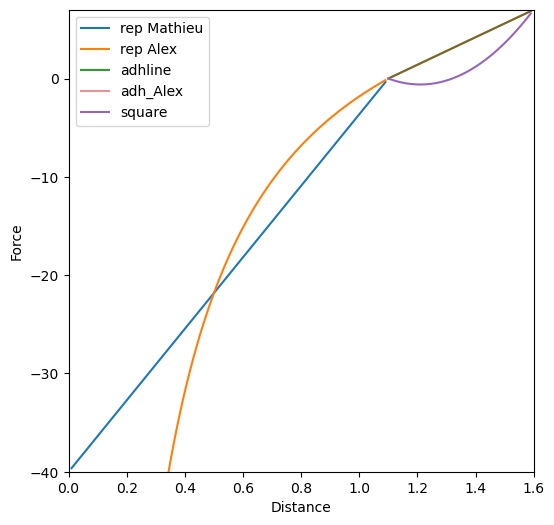

In [72]:
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 0.637*2048 #1308 # Micrometers
# time settings
TIME_SIMU = 90 # time simulation in minutes
DELTA_T = 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 1
# simulation parameters
MU = 1  # mobility in min.kg-1
F_REP = 40  # repulsive strength
F_ADH = 7 # 3 #4 #attractive strength force kg.um.min-2
R_EQ = 1.1 # 11  # equilibrium radius in um
R_0 = 1.6 # 16  # interaction radius in um
MIN_DISTANCE_INIT = R_EQ
NOISE = 10  # noise intensity
TAU = 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
# Cells definition
PACKING_FRACTION = 0.00003
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
# N = 2000
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 3 #um/min
velocity_magnitude_pop2 = 7 # um/min

COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

In [73]:
# In[Definition of the populations]
population1 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=1,\
                         min_distance=MIN_DISTANCE_INIT)
population2 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=1,\
                         min_distance=MIN_DISTANCE_INIT)

cells = population1.cells + population2.cells

surface = Surface()

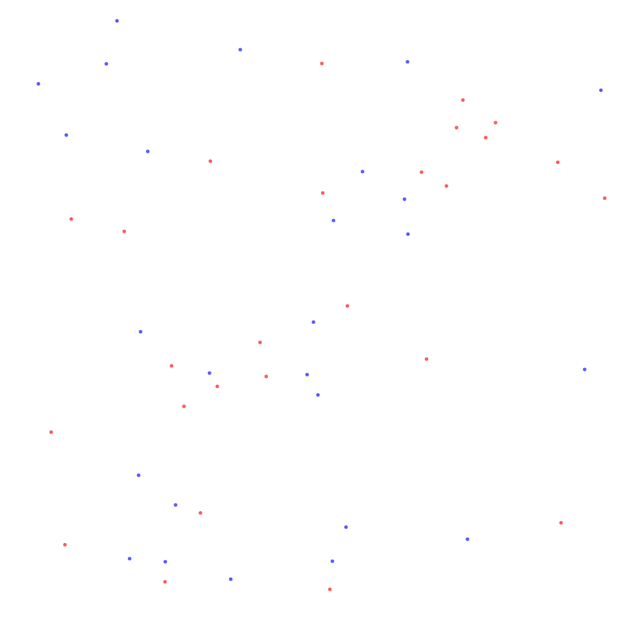

0


In [74]:
# In[initialisation]
positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device = device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])
PATH = f'/Users/souchaud/Desktop/simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
if not os.path.exists(PATH):
    os.mkdir(PATH)
else :
    print("WARNING : FOLDER DOES ALREADY EXIST!")
    sys.exit(0)
plot_environment(cells, space_size= SPACE_SIZE, req=R_EQ,
                 path_saving=PATH, iteration = 0)

In [75]:
import numpy as np
(35**2)*np.pi

3848.4510006474966

In [ ]:
# In[Simulation]
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)

while time < TIME_SIMU :
    #Paiwise distance.
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
      print("At least one distance is greater than the max distance.")

    # force_field calculation
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a = COEFF_CARRE, coeff_rep = 0.5)
    # displacement computing
    displacement = MU * force_field * DELTA_T +\
                   V0 * direction * DELTA_T
    # cells position evolution
    positions += displacement

    # border conditions
    positions = torch.remainder(positions, SPACE_SIZE)

    for cell, position, direct in zip(cells, positions, direction):
        cell.position = position.to(device)
        cell.direction = direct.to(device)
        # print(cell, position, direct)
    # direction update for next step
    direction = autovel(displacement, direction, TAU, NOISE, DELTA_T)
    # direction = autovel2( direction, noise)

    # plot the result
    marker_radius = 1.1
    marker_size = (np.pi) * marker_radius ** 2
    if iteration % PLOT_INTERVAL == 0:
      plot_environment(cells, path_saving = PATH, space_size = SPACE_SIZE, req=R_EQ, iteration = iteration)

    time += DELTA_T
    print(time)
    iteration += 1